<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Simple_Retail_Demand_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8: Retail analytics - Predictive Model Traning
---
*Created by Yossiri Adulyasak*

---

## Demo: Simplified retail prediction pipeline for a single item

### NOTE:###
This is a simplified version of the predictive model shown in the Module 1  for session 8. In this version, we run only the model for one item. Once you are familiar with this one, it will be easy to understand the full demo which consists of multiple items.

We begin by loading the required packages.

In [1]:
import pandas as pd
import numpy as np
import sklearn # Library for basic machine learning models
import lightgbm # LightGBM: a high-performance Gradient Boosting library
from sklearn import *

import matplotlib.pyplot as plt

# Import metrics to measure how "wrong" our predictions are
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

## *Custom function - Error calculations

First, we create a function to measure the quality of predictions

In [2]:
def evaluate_model(model_name, y_true, y_pred):
    # MAE: Average absolute difference. Easy to interpret (e.g., "off by 20 units").
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE: Root Mean Squared Error. Penalizes large errors more than MAE.
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE: Mean Absolute Percentage Error. Shows error as a % of actual sales.
    # We use numpy (np) to calculate: mean( abs( (Actual - Pred) / Actual ) ) * 100
    mape = np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

    # wMAPE: Weighted MAPE. Sum of Absolute Errors divided by the Sum of Actual Values
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

    # R2: How well the model explains the variance. 1.0 is perfect, 0.0 is useless.
    r2 = r2_score(y_true, y_pred)

    # Print the formatted results
    print(f"{model_name:18} | MAE: {mae:6.2f} | RMSE: {rmse:6.2f} | MAPE: {mape:6.2f}% | wMAPE: {wmape:6.2f}% | R2: {r2:.4f}")

    # -----------------------------------------------------------------------------
    # OUTPUT FORMATTING EXPLANATION
    # -----------------------------------------------------------------------------
    # The 'f' at the start (f"...") stands for "Formatted string". This is important so that Python
    # will know that the curly braces are part of the code (and the rest outside curly braces are text).
    # The 'f' inside the braces (:.2f) stands for "Fixed-point number" (standard decimal).
    # This f-string prints the results as a neat table row.
    # Breakdown of the syntax inside the curly braces {variable:formatting}:
    # 1. f{model_name:18}
    #    - :18 -> Reserves 18 characters of space (padding).
    #    - If the name is shorter, it adds spaces so the vertical pipes (|) align.
    # 2. {mae:6.2f}
    #    - :6  -> Reserves a total width of 6 characters (helps align digits).
    #    - .2f -> Rounds the number to exactly 2 decimal places.
    # 3. {r2:.4f}
    #    - .4f -> Rounds the number to exactly 4 decimal places.

# Block 1: Data input

In [3]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/EN/S08_09_Retail_Analytics/salesCereals.csv'

salesCereals = pd.read_csv(url)
salesCereals.head()

,Unnamed: 0,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,Desc,Category,Sub-Category,SUMPRICE,COUNTPRICE,AVGPRICE,RELPRICE
0,6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,0.0,0.0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.673490
1,8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,0.0,0.0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.709314
2,12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,0.0,0.0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.142784
3,13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.644319
4,14,2009-01-14,367.0,1600027564,56.0,48.0,42.0,152.32,2.72,3.07,1.0,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.974411


'UPC' stands for Universal Product Code, which can be understood as one SKU in this case and in our SCM terms in general. The code below helps us identify the SKUs by which we want to forecast and their corresponding data size (number of data instances). We can see that the number of instances for each UPC is similar and that there is no UPC with only a few data points. This is important because training a model on a small dataset may limit its generalization.

In [4]:
print(salesCereals.groupby('UPC').count())

            Unnamed: 0  WEEK_END_DATE  STORE_NUM  UNITS  VISITS  HHS  SPEND  \
UPC                                                                           
1111085319         156            156        156    156     156  156    156   
1111085350         156            156        156    156     156  156    156   
1600027527         156            156        156    156     156  156    156   
1600027528         156            156        156    156     156  156    156   
1600027564         155            155        155    155     155  155    155   
3000006340         133            133        133    133     133  133    133   
3800031829         155            155        155    155     155  155    155   

            PRICE  BASE_PRICE  FEATURE  DISPLAY  TPR_ONLY  Desc  Category  \
UPC                                                                         
1111085319    156         156      156      156       156   156       156   
1111085350    156         156      156      156       156

# Block 2: Feature engineering & preparation

We then organize the data by 'UPC.' The model presented here only runs on a predetermined subset of variables in the data. You can add or remove these explanatory variables based on your judgemental call.

Here we select only **one** upc to run the model.

In [5]:
feature_list = ['PRICE', 'FEATURE', 'DISPLAY','TPR_ONLY']

productList = salesCereals['UPC'].unique()
upc = 1111085319

X = salesCereals.loc[salesCereals['UPC']==upc][feature_list]
y = salesCereals.loc[salesCereals['UPC']==upc]['UNITS']
# Split into training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)


# Block 3: Model & algorithm (training & testing)

In the next two cells, we train and test two different types of models, namely Linear Regression and Tree Regression. The first line in each loop is to train the model and the second line is for testing the model's performance on unseen data. The next three lines compute the performance metrics we would like to measure. Then we compute metrics to show the performance of the model.

## Model 1: Linear regression

In [6]:
#Linear model

# Fit the model
regr = sklearn.linear_model.LinearRegression().fit(X_train,y_train)

# Measure the RSME on the training set (this is not a good measure, we simply want to see the difference)
trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_train, regr.predict(X_train)))
print(f"Train RMSE: {trainRMSE:6.2f}")

# Prediction on the test set
y_pred = regr.predict(X_test)

# Measure the prediction performances on the test set
evaluate_model("Linear Regression", y_test, y_pred)


Train RMSE:   7.77
Linear Regression  | MAE:   6.62 | RMSE:   8.20 | MAPE:  84.39% | wMAPE:  42.81% | R2: -0.0451


In order to see the impact of the price on the demand, we use a simple plot function below from mathplotlib to see how the demand would change when the price changes.

For more details of the plot function, please see: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


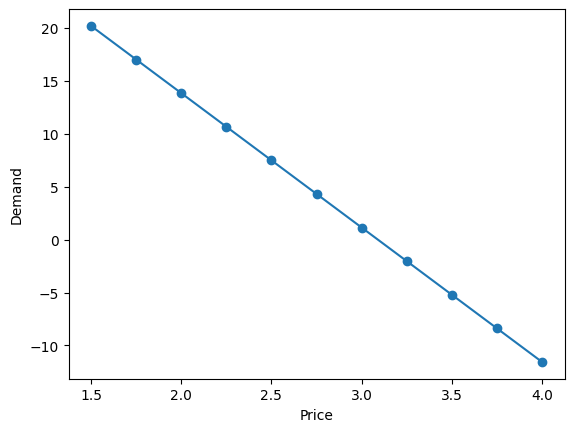

In [7]:
prices = [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
input_x = []

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, 0, 0, 0])

# obtain the predicted demands
predict_y = regr.predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

## Model 2: Linear regression with log-log transformation

We can also apply a natural logarithm transformation to both the 'PRICE' variable in 'X' and 'UNITS' in 'y' (target) data. This step is essential for fitting a log-log linear regression model, which is a well-known demand pricing model in the economic and revenue management literature. To avoid the issue of zero, we will add a constant (epsilon) to original values to avoid errors.

In [8]:
epsilon = 0.01 # Define a constant to handle potential zero values in log transformation

# Apply natural logarithm transformation to the target variable 'y', adding epsilon to avoid log(0)
y_train_log = np.log(y_train + epsilon)
y_test_log = np.log(y_test + epsilon)

# Create copies of the feature dataframes to apply transformations
X_train_log = X_train.copy()
X_test_log = X_test.copy()

# Apply natural logarithm transformation to 'PRICE' adding epsilon
X_train_log['PRICE'] = np.log(X_train_log['PRICE'] + epsilon)

X_test_log['PRICE'] = np.log(X_test_log['PRICE'] + epsilon)

# Print the head of the transformed dataframes to verify the transformation
print("Data transformed for log-log regression:")
print("y_train_log head:\n", y_train_log.head())
print("X_train_log head:\n", X_train_log.head())

Data transformed for log-log regression:
y_train_log head:
 189    2.303585
760    3.526655
959    3.091497
670    1.947338
126    2.996232
Name: UNITS, dtype: float64
X_train_log head:
         PRICE  FEATURE  DISPLAY  TPR_ONLY
189  0.604316      0.0      0.0       0.0
760  0.636577      0.0      0.0       0.0
959  0.636577      0.0      0.0       0.0
670  0.512824      0.0      0.0       0.0
126  0.512824      0.0      0.0       1.0


In [9]:
regr_loglog = sklearn.linear_model.LinearRegression().fit(X_train_log, y_train_log)
print("Log-Log Linear Regression model trained successfully.")

# Measure the RSME on the training set (this is not a good measure, we simply want to see the difference)
trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_train, regr_loglog.predict(X_train)))
print(f"Train RMSE: {trainRMSE:6.2f}")

# Prediction on the test set
y_pred_log = regr_loglog.predict(X_test)

# Since the prediction is in log unit, we need to convert it back
y_pred = np.exp(y_pred_log)

# Measure the prediction performances on the test set
evaluate_model("Linear Regression (log-log)", y_test, y_pred)

Log-Log Linear Regression model trained successfully.
Train RMSE:  17.81
Linear Regression (log-log) | MAE:  10.55 | RMSE:  12.83 | MAPE:  65.36% | wMAPE:  68.22% | R2: -1.5570


### Plotting both Linear and Log-Log Linear Regression Demand Curves

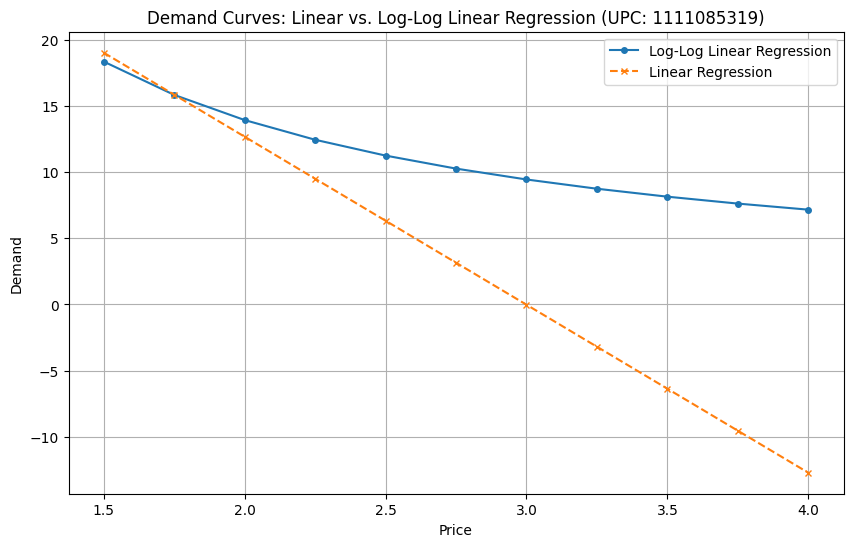

Combined demand curve plot generated.


In [10]:
# Generate predictions for the linear regression model using the same price range as the log-log model
linear_input_x = []
for p in prices:
  # Use the same feature values for linear model as assumed for the log-log plot
  # We are assuming FEATURE=1, DISPLAY=0, TPR_ONLY=0 for the plot
  linear_input_x.append([p, 1, 0, 0])

linear_input_x_df = pd.DataFrame(linear_input_x, columns=feature_list)
predict_y_linear = regr.predict(linear_input_x_df)

# Generate predictions for the log-log linear regression model
loglog_input_x = []
for p in prices:
  # Apply log transformation to PRICE for log-log model
  log_price = np.log(p + epsilon) # epsilon is defined earlier
  loglog_input_x.append([log_price, 1, 0, 0])

loglog_input_x_df = pd.DataFrame(loglog_input_x, columns=feature_list)
predict_y_log_transformed = regr_loglog.predict(loglog_input_x_df)
predict_y_original = np.exp(predict_y_log_transformed) # Convert back from log

plt.figure(figsize=(10, 6))
plt.plot(prices, predict_y_original, label='Log-Log Linear Regression', marker='o', markersize=4)
plt.plot(prices, predict_y_linear, label='Linear Regression', marker='x', markersize=4, linestyle='--')

plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand Curves: Linear vs. Log-Log Linear Regression (UPC: ' + str(upc) + ')')
plt.legend()
plt.grid(True)
plt.show()

print("Combined demand curve plot generated.")

Likewise, we obtain the tree regression results by simply changing the function name. Here you can try the regression tree and random forest (second model) and Light GBM (third model) if you outcomment it.  Light GBM is a machine learning technique where prediction trees are built sequentially. Each new tree attempts to correct the errors (residuals) made by the previous ones.

In [11]:
#Tree models
# regr = sklearn.tree.DecisionTreeRegressor(random_state = 0).fit(X_train,y_train) # standard regression tree
# regr = sklearn.ensemble.RandomForestRegressor(random_state = 0).fit(X_train,y_train) # random forest tree
regr = lightgbm.LGBMRegressor(verbosity=-1).fit(X_train,y_train) # Light Gradient-Boosting Machine


# Measure the RSME on the training set
trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_train, regr.predict(X_train)))

# Prediction on the test set
y_pred = regr.predict(X_test)

# Measure the prediction performances on the test set
evaluate_model("Tree-based model", y_test, y_pred)

Tree-based model   | MAE:   6.30 | RMSE:   7.71 | MAPE:  78.33% | wMAPE:  40.74% | R2: 0.0762


In [12]:
# plot to see how the results look like when changing prices
input_x = []

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  # Corrected to match the 4 features the model was trained on
  input_x.append([p, 1, 0, 0])

input_x

[[1.5, 1, 0, 0],
 [1.75, 1, 0, 0],
 [2.0, 1, 0, 0],
 [2.25, 1, 0, 0],
 [2.5, 1, 0, 0],
 [2.75, 1, 0, 0],
 [3.0, 1, 0, 0],
 [3.25, 1, 0, 0],
 [3.5, 1, 0, 0],
 [3.75, 1, 0, 0],
 [4.0, 1, 0, 0]]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


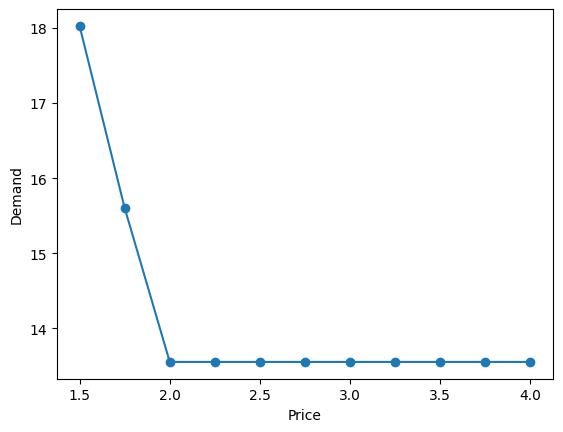

In [13]:
# obtain the predicted demands
predict_y = regr.predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

# Block 4: Model selection

By comparing the average result, we can see that the linear regression model slightly outperformed the decision tree regression and did not overfit the data. In addtion, the predicted function has a better representation since the changes are monotonic (from the plots). Therefore, we proceed with the linear regression model for the whole dataset by replacing 'X_train' with 'X'. Given that the model has 'seen' the whole dataset, its forecast errors normally decrease. Therefore, we will save the trained model and use it for the new data which will be used in the optimization models in the next session.

In [14]:
# Selected model

# Fit the model on the entire dataset
regr = sklearn.linear_model.LinearRegression().fit(X,y)

## Save trained models

**Option 1 Jupyter**: If you use Jupyter, you can save it to a local folder. The code below will put it in the current folder.

In [15]:
cwd = './'

**Option 2 Colab**: If you use Colab, in addition to downloading the results as we did in the previous session (not shown here), you can also save to your Google Drive.

In [16]:
# we need to remount Google Drive in order to save into it
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we can save the files to the folder indicated by using the code below.

In [17]:
# save the models to drive (here we save model only for one UPC).
import pickle

filename = cwd+str(upc)+'_single_upc_demand_model.sav'
# save the model to disk
pickle.dump(regr, open(filename, 'wb'))

If you want to load the trained model, after mounting the drive above, it can be loaded directly

In [18]:
# load the model back to an object regr_loaded
regr_loaded = pickle.load(open(filename, 'rb'))